In [151]:
import pandas as pd
import numpy as np
import logging
from typing import TypeVar
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Self = TypeVar('Self')
logging.getLogger().setLevel(logging.INFO)

class Error(Exception):
    """Base class for other exceptions."""

    pass

class NotFittedError(Error):
    """Raised when the model has not been fitted."""

    pass

In [152]:
ml_ratings = pd.read_csv('data/ml-1m/ratings.dat', sep='::', engine='python', names=['UserId', 'MovieId', 'Rating', 'Timestamp'])

ml_users = pd.read_csv('data/ml-1m/users.dat', sep='::', engine='python', names=['UserId', 'Age', 'Gender', 'Occupation', 'ZipCode'])

ml_movies = pd.read_csv('data/ml-1m/movies.dat', sep='::', engine='python', names=['MovieId', 'Title', 'Genres'])

In [153]:
ml_ratings.head()

,UserId,MovieId,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [154]:
ml_users.head()

,UserId,Age,Gender,Occupation,ZipCode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [155]:
ml_movies.head()

,MovieId,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [156]:
imdb_name = pd.read_csv('data/name.basics.tsv', sep='\t')

imdb_title = pd.read_csv('data/title.basics.tsv', sep='\t')

/var/folders/fp/px6c9css3ssdd44wyd5vn8vm0000gn/T/ipykernel_25511/3979523670.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_title = pd.read_csv('data/title.basics.tsv', sep='\t')


In [157]:
imdb_name.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0072308,tt0050419,tt0053137,tt0027125"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack,archive_footage","tt0037382,tt0075213,tt0117057,tt0038355"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,music_department,producer","tt0057345,tt0049189,tt0056404,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,writer,music_department","tt0072562,tt0077975,tt0080455,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0083922,tt0050976,tt0069467"


In [158]:
imdb_title.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [159]:
ml_movies['Year'] = ml_movies['Title'].str.extract(r'\((\d{4})\)')

ml_movies['Title'] = ml_movies['Title'].str.replace(r' \(\d{4}\)', '', regex=True)

ml_movies.head()

,MovieId,Title,Genres,Year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995


In [160]:
df_movies = ml_movies.merge(imdb_title, left_on=['Title', 'Year'], right_on=['primaryTitle', 'startYear'] , how='inner')

df_movies.drop(columns=['primaryTitle', 'originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes', 'genres', 'titleType'], inplace=True)

In [161]:
df_movies.head()

,MovieId,Title,Genres,Year,tconst
0,1,Toy Story,Animation|Children's|Comedy,1995,tt0114709
1,2,Jumanji,Adventure|Children's|Fantasy,1995,tt0113497
2,3,Grumpier Old Men,Comedy|Romance,1995,tt0113228
3,4,Waiting to Exhale,Comedy|Drama,1995,tt0114885
4,5,Father of the Bride Part II,Comedy,1995,tt0113041


In [162]:
imdb_name_exploded = imdb_name.assign(tconst=imdb_name['knownForTitles'].str.split(',')).explode('tconst')

imdb_name_exploded.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,tconst
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0072308,tt0050419,tt0053137,tt0027125",tt0072308
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0072308,tt0050419,tt0053137,tt0027125",tt0050419
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0072308,tt0050419,tt0053137,tt0027125",tt0053137
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0072308,tt0050419,tt0053137,tt0027125",tt0027125
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack,archive_footage","tt0037382,tt0075213,tt0117057,tt0038355",tt0037382


In [163]:
# Map each tconst to the corresponding primaryName
tconst_to_name = imdb_name_exploded.groupby('tconst')['primaryName'].apply(list).to_dict()

{k: tconst_to_name[k] for k in list(tconst_to_name)[:5]}

{'\\N': ['Eivind Fredagsvik Øyangen',
  'Christian Daugherty',
  'James 52X',
  'Per Aabel',
  'Linus Aaberg',
  'Linus Aaberg',
  'John Aalberg',
  'Joan Aalestrup',
  'Charles Aaron',
  'Lindy Aaron',
  'Nancy-Rae Aaron',
  'Major Aaxton',
  'Elena Ababy',
  'Loraine Abate',
  'Marie Abate',
  'Leo Abbey',
  'Billy Abbott',
  'Imogene Abbott',
  'Stephen Abbott',
  'Sylvia Abbott',
  'Wendu Abbott',
  'Abd-El-Krim',
  'Mario Abdah',
  'Kamaran Abdalla',
  'Mohamed Abdel Gawad',
  'B. Abdilmanov',
  'Eddie Abdo',
  'Ol Abdou',
  'Ali Abdulla',
  'Eve Abdullah',
  'Zauther Abdullah',
  'Abdulmalek',
  'I. Abdusalimov',
  'Rob Abel',
  'Jane Abernethy',
  'Arline Abers',
  'Jean Able',
  'Lawrence Able',
  'Charles Abraham',
  'Harry Abrahams',
  'Rosemarie Abrahamsson',
  'A. Abramovich',
  'Katharine Abrams',
  'Leopold Abramson',
  'Juan J. Abrines',
  'Christine Abrusci',
  'Franco Accatino',
  'Acce Acce',
  'Roberta Achtenberg',
  'Walter Achuga',
  'Martha Acker',
  'Boyd Ackerma

In [164]:
def map_cast(tconst):
    """Map tconst to primary names."""
    return tconst_to_name.get(tconst, [])

# Create a new column 'Cast' by mapping the 'tconst' column
df_movies['Cast'] = df_movies['tconst'].apply(map_cast)

df_movies.head()

,MovieId,Title,Genres,Year,tconst,Cast
0,1,Toy Story,Animation|Children's|Comedy,1995,tt0114709,"[Tim Allen, John Ratzenberger, Jim Varney, Joh..."
1,2,Jumanji,Adventure|Children's|Fantasy,1995,tt0113497,"[Bonnie Hunt, Bebe Neuwirth, Adam Hann-Byrd, R..."
2,3,Grumpier Old Men,Comedy|Romance,1995,tt0113228,"[James Andelin, Richard C. Berman, Les Brown, ..."
3,4,Waiting to Exhale,Comedy|Drama,1995,tt0114885,"[Whitney Houston, Kenneth 'Babyface' Edmonds, ..."
4,5,Father of the Bride Part II,Comedy,1995,tt0113041,"[Rodrigo Botero, William Akey, Sam Anderson, D..."


In [165]:
user_item_matrix = ml_ratings.pivot(index='UserId', columns='MovieId', values='Rating')

movie_means = user_item_matrix.mean()

user_item_matrix = user_item_matrix.apply(lambda x: x.fillna(movie_means[x.name]), axis=0)

user_item_matrix

MovieId,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserId,,,,,,,,,,,,,,,,,,,,,
1,5.000000,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
2,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
3,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
4,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
5,4.146846,3.201141,3.016736,2.729412,3.006757,2.000000,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,4.146846,3.201141,3.016736,2.000000,3.006757,3.000000,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
6037,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
6038,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928


In [166]:
n_users, n_items = user_item_matrix.shape

In [167]:
# Initialise random matrices

latent_dim = 120  # The dimension of latent space is an hyperparameter of the model

user_mat = np.random.rand(n_users, latent_dim)
item_mat = np.random.rand(latent_dim, n_items)

assert (
    np.dot(user_mat, item_mat).shape == user_item_matrix.shape
), "Something is wrong with matrices dimensions."

In [168]:
# Define Funk SVD


class FunkSVD:
    """Object to perform matrix factorisation using a basic form of FunkSVD with no regularisation.

    Parameters
    ----------
    latent_dim : int
        The dimension of the latent space for the FunkSVD algorithm.


    Attributes
    ----------
    user_mat_ : np.ndarray
        Attribute calculated only after calling the fit method.
        It is the latent matrix representing users encodings.

    item_mat_ : np.ndarray
        Attribute calculated only after calling the fit method.
        It is the latent matrix representing items encodings.

    mse_ : float
        Attribute calculated only after calling the fit method.
        It is the mean squared error between reconstructed matrix and ratings one.

    hist : Dict
        Attribute containing lists of quantities varying during training.


    Methods
    -------
    fit
        The method performing the training for the model.

    predict_rating
        The method predicting a user rating for a certain item.

    """

    def __init__(self, latent_dim: int, learning_rate: float = 1.0e-5, regularization: float = 0.002):
        """Constructor for the class"""
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.hist = {}

    @staticmethod
    def _random_initialise(n: int, m: int, seed: int = None) -> np.ndarray:
        """Private method to initialise a random matrix

        Parameters
        ----------
        n : int
            Number of rows
        m : int
            Number of columns
        seed : int, optional
            The random seed to make results reproducible, by default None.

        Returns
        -------
        np.ndarray
            The randomly initialised array of shape (n,m).
        """
        if seed is not None:
            np.random.seed(seed)

        return np.random.rand(n, m)

    def fit(
        self,
        ratings: np.ndarray,
        r_mask: np.ndarray,
        n_users: int,
        n_items: int,
        max_iter: int = 300,
    ) -> Self:
        """Fit Method for the FunkSVD object.

        Parameters
        ----------
        ratings : np.ndarray
            The ratings matrix.
        r_mask : np.ndarray
            The mask matrix to determine whether the ratings are defined.
        n_users : int
            Number of users.
        n_items : int
            Number of items.
        max_iter : int, optional
            Number of iterations for the algorithm.
            Default: 300
        learning_rate : float, optional
            Learning rate for gradient descent updates.
            Default: 1.e-5

        Returns
        -------
        None
            One only has an updated version of the object.
            The method creates the attributes `user_mat_` and `item_mat_`.
        """
        # Initialise user and items matrices
        user_mat = self._random_initialise(n_users, self.latent_dim)
        item_mat = self._random_initialise(self.latent_dim, n_items)

        # Initialise an empty list for sum of errors
        self.hist["mse"] = []

        # Loop over iterations
        for _ in tqdm(range(max_iter)):
            # Create boolean mask of non-zero entries in rating matrix
            mask = r_mask > 0

            # compute difference matrix
            diff_mat = ratings - np.dot(user_mat, item_mat)
            n_ratings = len(diff_mat)

            # Normalise the difference
            diff_mat /= n_ratings

            # compute mean squared error
            mse = np.sum(np.square(diff_mat[mask]))
            self.hist["mse"].append(mse)

            # update user and items matrices
            user_mat += self.learning_rate * (np.dot(diff_mat, item_mat.T) - self.regularization * user_mat)
            item_mat += self.learning_rate * (np.dot(user_mat.T, diff_mat) - self.regularization * item_mat)

        self.mse_ = mse
        self.user_mat_ = user_mat
        self.item_mat_ = item_mat

        logging.info(
            f"""Training complete.
        \nMean squared error: {self.mse_:.3f}"""
        )

    def predict_rating(self, user_id: int, item_id: int) -> float:
        """The method predicting the rating the user would give to the item.

        Parameters
        ----------
        user_id : int
            id of the user.
        item_id : int
            id of the item.

        Returns
        -------
        float
            The predicted rating.
        """
        if not hasattr(self, "user_mat_"):
            message = "The model has not been fitted yet. Please call the `fit` method before."
            raise NotFittedError(message)

        return np.dot(self.user_mat_[user_id - 1, :], self.item_mat_[:, item_id - 1])

In [224]:
def combine_user_vectors(user_vec_1, user_vec_2):
    """Function to combine two user vectors.

    Parameters
    ----------
    user_vec_1 : np.ndarray
        The first user vector.
    user_vec_2 : np.ndarray
        The second user vector.
    
    Returns
    -------
    np.ndarray
        The combined user vector.
    """
    return (user_vec_1 + user_vec_2) / 2
    
def predict_couple_ratings(funk_svd, user_id_1, user_id_2):
    """Function to predict the ratings of a couple for all the movies.
    
    Parameters
    ----------
    funk_svd : FunkSVD
        The fitted FunkSVD model.
    user_id_1 : int
        The id of the first user.
    user_id_2 : int
        The id of the second user.
    
    Returns
    -------
    np.ndarray
        The predicted ratings for all the movies.
    """
    user_vec_1 = funk_svd.user_mat_[user_id_1 - 1, :]
    user_vec_2 = funk_svd.user_mat_[user_id_2 - 1, :]

    combined_user_vec = combine_user_vectors(user_vec_1, user_vec_2)

    predicted_ratings = np.dot(combined_user_vec, funk_svd.item_mat_)

    return predicted_ratings

def genre_similarity(movie_genres_1, movie_genres_2):
    """Function to compute the similarity between two movies based on their genres.
    
    Parameters
    ----------
    movie_genres_1 : str
        The genres of the first movie.
    movie_genres_2 : str
        The genres of the second movie.
        
    Returns
    -------
    float
        The similarity between the two movies based on their genres.
    """
    genres_1 = set(movie_genres_1.split('|'))
    genres_2 = set(movie_genres_2.split('|'))
    return len(genres_1.intersection(genres_2)) / len(genres_1.union(genres_2))

def suggest_movies_for_couple(funk_svd, user_id_1, user_id_2, df_movies, n_recommendations=10):
    """Function to suggest movies for a couple based on their ratings and movie features.
    
    Parameters
    ----------
    funk_svd : FunkSVD
        The fitted FunkSVD model.
    user_id_1 : int
        The id of the first user.
    user_id_2 : int
        The id of the second user.
    df_movies : pd.DataFrame
        The dataframe containing the movies features.
    n_recommendations : int, optional
        The number of movies to recommend.
        
    Returns
    -------
    pd.DataFrame
        The dataframe containing the recommended movies.
    """
    couple_ratings = predict_couple_ratings(funk_svd, user_id_1, user_id_2)

    couple_ratings = couple_ratings[:df_movies.shape[0]]

    
    movie_predictions = pd.DataFrame({
        'MovieId': df_movies['MovieId'],
        'PredictedRating': couple_ratings
    })

    movie_predictions = movie_predictions.merge(df_movies, on='MovieId')

    max_year = int(df_movies['Year'].max())
    movie_predictions['YearScore'] = movie_predictions['Year'].astype(int) / max_year
    
    movie_predictions['GenreScore'] = movie_predictions.apply(
        lambda row: genre_similarity(row['Genres'], df_movies[df_movies['MovieId'] == row['MovieId']]['Genres'].values[0]), axis=1
    )
    
    movie_predictions['CoupleScore'] = (
        0.5 * movie_predictions['PredictedRating'] +
        0.4 * movie_predictions['GenreScore'] +
        0.1 * movie_predictions['YearScore']
    )

    movie_predictions = movie_predictions.sort_values(by='CoupleScore', ascending=False)

    movie_predictions = movie_predictions.drop_duplicates(subset='Title')
    
    top_movies = movie_predictions.head(n_recommendations)
    return top_movies

In [170]:
# Split the data into training and test sets
train_ratings, test_ratings = train_test_split(ml_ratings, test_size=0.2, random_state=42)

user_item_matrix_train = train_ratings.pivot(index='UserId', columns='MovieId', values='Rating')

movie_means_train = user_item_matrix_train.mean()

# Fill missing values with the mean rating for each movie
user_item_matrix_train = user_item_matrix_train.apply(lambda x: x.fillna(movie_means_train[x.name]), axis=0)


# Create a mask for the ratings matrix
r_mask_train = user_item_matrix_train.notna().astype(int).values


user_item_matrix_test = test_ratings.pivot(index='UserId', columns='MovieId', values='Rating')

movie_means_test = user_item_matrix_test.mean()

user_item_matrix_test = user_item_matrix_test.apply(lambda x: x.fillna(movie_means_test[x.name]), axis=0)

r_mask_test = user_item_matrix_test.notna().astype(int).values

ratings_matrix_train = user_item_matrix_train.values
ratings_matrix_test = user_item_matrix_test.values

In [248]:
n_users_train, n_items_train = ratings_matrix_train.shape

funk_svd = FunkSVD(latent_dim=latent_dim, learning_rate=1.e-3, regularization=1.e-2)

funk_svd.fit(ratings_matrix_train, r_mask_train, n_users_train, n_items_train, max_iter=1000)

100%|██████████| 1000/1000 [36:43<00:00,  2.20s/it]   
INFO:root:Training complete.
        
Mean squared error: 0.401


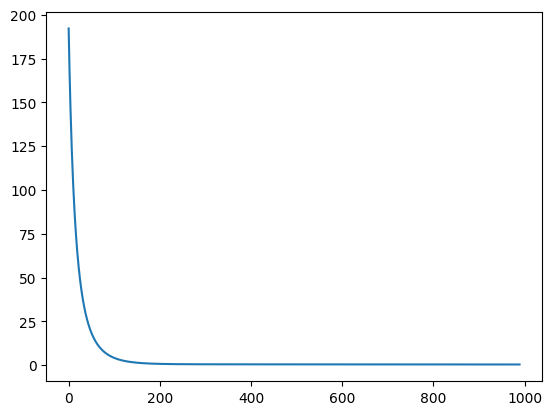

In [249]:
from matplotlib import pyplot as plt


plt.plot(funk_svd.hist["mse"][10:]);

In [250]:
def evaluate_model(funk_svd, ratings_matrix_test, r_mask_test):
    """Function to evaluate the FunkSVD model on the test set.

    Parameters
    ----------
    funk_svd : FunkSVD
        The fitted FunkSVD model.
    ratings_matrix_test : np.ndarray
        The ratings matrix for the test set.
    r_mask_test : np.ndarray
        The mask matrix for the test set.
    
    Returns
    -------
    float
        The mean squared error of the model on the test set.
    float
        The root mean squared error of the model on the test set.
    """
    predictions = []
    actuals = []

    n_users_test, n_items_test = ratings_matrix_test.shape

    for user_id in range(1, n_users_test + 1):
        for item_id in range(1, n_items_test + 1):
            if r_mask_test[user_id - 1, item_id - 1] > 0: 
                predicted_rating = funk_svd.predict_rating(user_id, item_id)
                actual_rating = ratings_matrix_test[user_id - 1, item_id - 1]
                predictions.append(predicted_rating)
                actuals.append(actual_rating)

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    return mse, rmse

In [251]:
mse, rmse = evaluate_model(funk_svd, ratings_matrix_test, r_mask_test)
print(f"Model Evaluation - MSE: {mse:.4f}, RMSE: {rmse:.4f}")

Model Evaluation - MSE: 1.5723, RMSE: 1.2539


In [253]:
user_id_1 = 1
user_id_2 = 2

# Suggest the top 10 movies for the couple
top_movies = suggest_movies_for_couple(funk_svd, user_id_1, user_id_2, df_movies, n_recommendations=10)
print(f"Top 10 recommended movies for users {user_id_1} and {user_id_2}:")
print(top_movies[['Title', 'PredictedRating', 'CoupleScore']])

Top 10 recommended movies for users 1 and 2:
                               Title  PredictedRating  CoupleScore
3496                 Happy Go Lovely         5.825549     3.410325
543   What's Love Got to Do with It?         5.789475     3.394388
3957           Suddenly, Last Summer         5.611174     3.303537
1774                       Artemisia         5.403029     3.201364
1684        Free Willy 3: The Rescue         5.369569     3.184635
2357           Young Doctors in Love         5.364630     3.181415
1031                        Gaslight         5.347170     3.170785
3854                       Near Dark         5.342184     3.170442
3997                          Kronos         5.331876     3.164588
2494                     First Blood         5.314290     3.156245
